# 06.03 - Is it right?

Writing a Machine Learning algorithm is only half the work.
To use such an algorithm to produce a meaningful model
and to be able to say that the predictions made by this model
are likely correct is often an even harder job.
Let us import a handful of useful things,
we will go through the use of these procedures when we need them.

![Neighbours](skl-neighbours.svg)

<div style="text-align:right;"><sup>skl-neighbours.svg</sup></div>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

We will also reconstruct our $k$ nearest neighbors algorithm.
We know how the algorithm works hence we should take it for a ride.

In [ ]:
class MyKNN(object):
    def __init__(self, k: int = 1) -> None:
        self.k_ = k

    def fit(
        self,
        X: np.ndarray[tuple[int, int], np.dtype[np.number]],
        y: np.ndarray[tuple[int], np.dtype[np.integer]],
    ) -> None:
        self.X_ = X
        self.y_ = y

    def predict(
        self,
        new_X: np.ndarray[tuple[int, int], np.dtype[np.number]],
    ) -> np.ndarray[tuple[int], np.dtype[np.integer]]:
        sq_dist_dim = (self.X_[:, np.newaxis, :] - new_X[np.newaxis, :, :]) ** 2
        sq_dist = sq_dist_dim.sum(axis=-1)
        self.nearest_ = np.argpartition(sq_dist, self.k_, axis=0)
        new_y = self.y_[self.nearest_[: self.k_, :]]
        new_y = np.apply_along_axis(
            lambda x: np.bincount(x, minlength=2), axis=0, arr=new_y
        )
        return new_y.argmax(axis=0)

The `make_blobs` procedure build a random dataset,
a dataset that is within the limitations of our $k$ nearest neighbor implementation.
We ask for $30$ points in $2$ dimensions, these will have $2$ centers:
class $0$ which we will call *blue*, and class $1$ which we will call *yellow*.
The randomness and spread of the blobs is fixed to generate one very specific dataset.

After that we generate $6$ more points, these we will call *green*.
These new green points are data we have no knowledge whether they
belong to the blue or yellow group.
We will use our $k$ nearest neighbor algorithm to build a model
that will predict the belonging of the green points.

Since $k$ is a hyperparameter - a free value - we can choose any value for it.
We will choose $1$ and $5$ for $k$ and see how the results of classifying
with these two models compare.

(array([0, 1, 1, 0, 0, 1]), array([0, 1, 0, 0, 1, 1]))

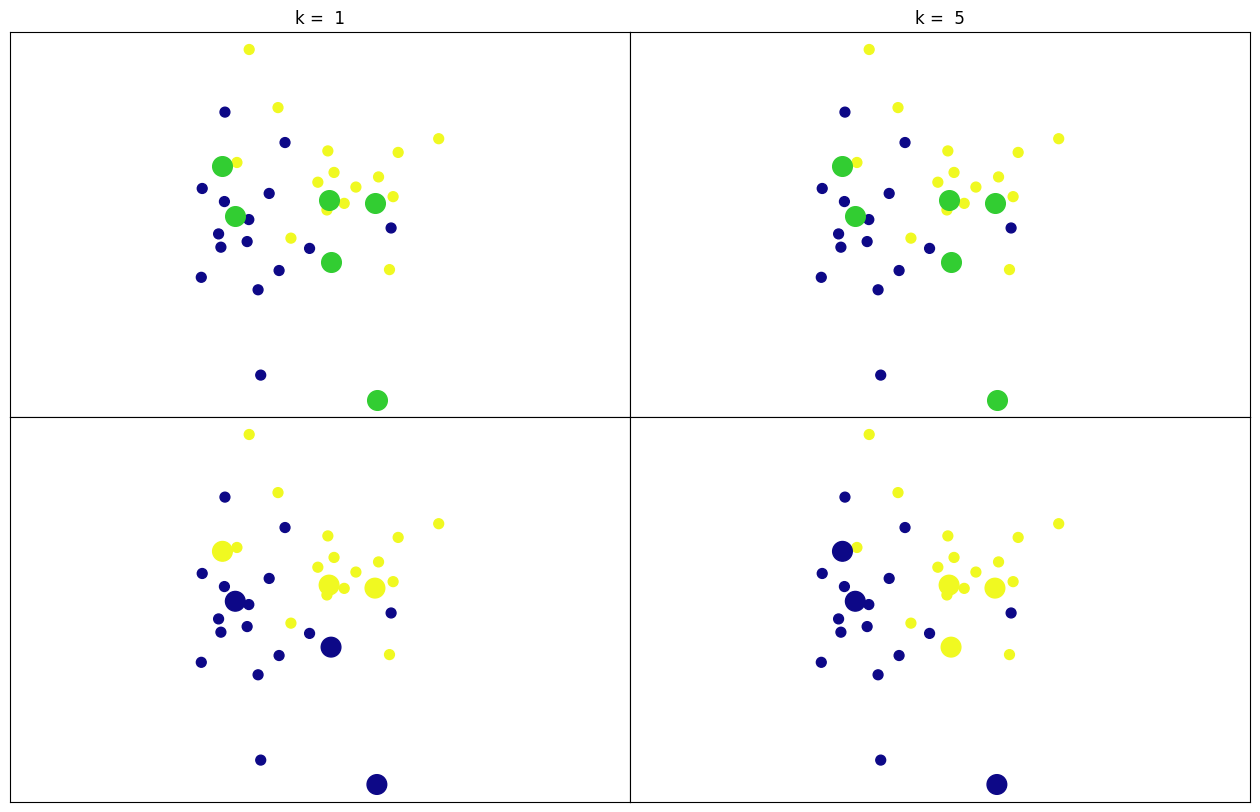

In [3]:
random_state = 27
rng = np.random.RandomState(random_state)
X, y = make_blobs(
    30,
    2,
    centers=2,
    cluster_std=0.2,
    center_box=(0, 1),
    random_state=random_state,
)
new_X = rng.rand(6, 2)

knn_left = MyKNN(k=1)
knn_left.fit(X, y)
new_yl = knn_left.predict(new_X)

knn_right = MyKNN(k=5)
knn_right.fit(X, y)
new_yr = knn_right.predict(new_X)

fig, ax = plt.subplots(2, 2, figsize=(16, 10))
fig.subplots_adjust(hspace=0, wspace=0)
ax[0, 0].set_title("k =  1")
ax[0, 0].scatter(X[:, 0], X[:, 1], s=50, c=y, cmap="plasma")
ax[0, 0].scatter(new_X[:, 0], new_X[:, 1], s=200, color="limegreen")
ax[1, 0].scatter(X[:, 0], X[:, 1], s=50, c=y, cmap="plasma")
ax[1, 0].scatter(new_X[:, 0], new_X[:, 1], s=200, c=new_yl, cmap="plasma")
ax[0, 1].set_title("k =  5")
ax[0, 1].scatter(X[:, 0], X[:, 1], s=50, c=y, cmap="plasma")
ax[0, 1].scatter(new_X[:, 0], new_X[:, 1], s=200, color="limegreen")
ax[1, 1].scatter(X[:, 0], X[:, 1], s=50, c=y, cmap="plasma")
ax[1, 1].scatter(new_X[:, 0], new_X[:, 1], s=200, c=new_yr, cmap="plasma")
for axi in ax.flat:
    axi.axis("equal")
    axi.set_xticks([], [])
    axi.set_yticks([], [])
new_yl, new_yr

On the left, where we used $k$ as $1$, we see northern green points
classified as yellow and the southern green points as blue.
On the right, where we used $k$ as $5$, we see the north-eastern green points
classified as yellow and the south-western green points classified as blue.
We also output the final classification made by our models for the green points,
$0$ means a blue prediction and $1$ a yellow one.

The algorithm works but the difference in the classification when we change $k$ is considerable.
Which of the models is right?  Is any of them right?
Is there a way for us to know which value of $k$
is more likely to produce good classification for the green points?

We cannot use the green points to check whether we are classifying
them correctly because we do not know what they should be
classified as in the first place.
The only points we know the labels for are the points
generated when building the blob.
We must use the points for which we know the labels
to validate out classifier (model).
There are several ways to do it, let's start experimenting.

How **NOT** to do it:

In [4]:
knn = MyKNN(k=1)
knn.fit(X, y)
new_y = knn.predict(X)
error = (y - new_y) ** 2
error.mean()

np.float64(0.0)

Here we train (fit) our model with $k$ as $1$.
Then we predict the labels for each point.
Finally we take the difference between what we predicted and what are the true labels.
We square the differences so they are all positive and stake the mean.
If there are no differences whatsoever the final result shall be zero.
This is a simple form of an evaluation technique called appropriately:
*mean square error*.

And the result for $k$ as $1$ is indeed zero.
There have been no error in the predictions performed by our model.
A perfect model!
Which means $k$ as $5$ must perform worse, right?

In [5]:
knn = MyKNN(k=5)
knn.fit(X, y)
new_y = knn.predict(X)
error = (y - new_y) ** 2
error.mean()

np.float64(0.2)

And yes, $k$ as $5$ performs with considerable error.
There is something fishy about this.
Can you tell?

When we used $k$ as $1$ each point we predicted has a closest
point to itself in the training set at exactly $0$ distance - itself!
One word used to describe such behavior is *overfitting*,
and in this case it is maximum overfitting.
We will come back to that concept eventually for now it is
sufficient to say that: knowing that each point is closest
to itself does not tell us anything about how that classification
may help with figuring out the correct grouping for the green points.

To ask about the green points is to ask about data that our model
has not been trained with, data that the model has not seen before.
But we cannot use the greens since we do not have labels for them.
Thankfully we could do a trick.
We can train our model with a subset of the data from the set
we know the labels for.
After that, we will check the model prediction errors using the
remaining data points for which we know the label for.

`sklearn` has an automated procedure for this.
`train_test_split` divides a set of data, both features and labels,
into a training and testing sets.
The division happens at random, according to the ratio given in `test_size`.
We will fix the random number generator for the time being.

To evaluate the performance of our models we will use the
`accuracy_score` and `f1_score` procedures.
These take the known labels and the predictions and output
a value between $0$ and $1$,
where (contrary to our manual attempts above) $1$ is the perfect score
and $0$ the worse possible score.
And since we have all this automation we will run the evaluation
in a loop and attempt several more values for $k$.

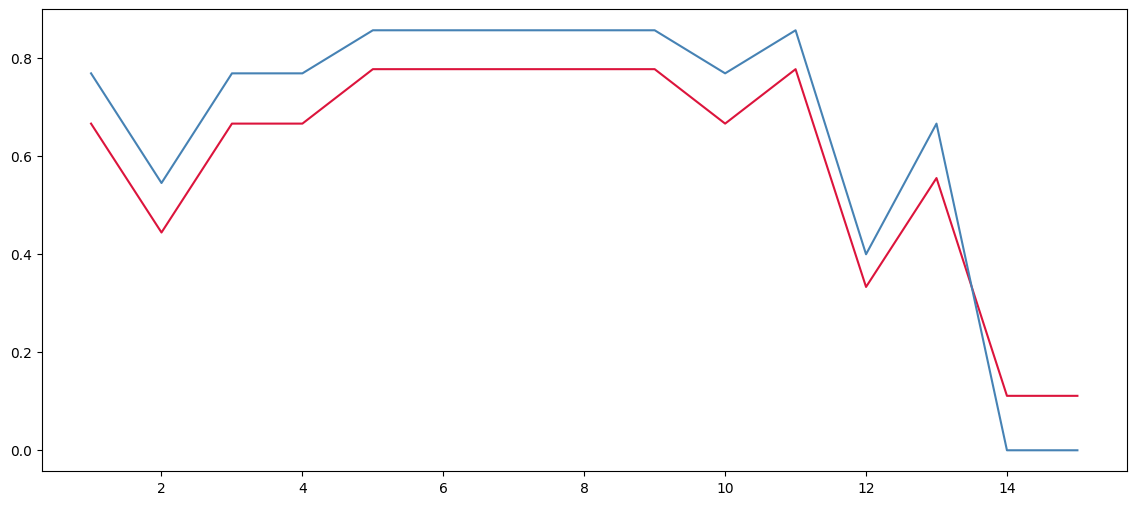

In [6]:
train_X, test_X, train_y, test_y = train_test_split(
    X, y, random_state=5, test_size=0.3
)
accuracy = []
f1_scores = []
k_vals = list(range(1, 16))
for k in k_vals:
    knn = MyKNN(k=k)
    knn.fit(train_X, train_y)
    new_y = knn.predict(test_X)
    accuracy.append(accuracy_score(test_y, new_y))
    f1_scores.append(f1_score(test_y, new_y))

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(k_vals, accuracy, color="crimson")
ax.plot(k_vals, f1_scores, color="steelblue");

On this graph of $k$ values we can argue that a value of $5$ is indeed a good one.
The smaller the value of $k$ the faster the model runs,
hence our decision should be for the smallest value
which still gives a good score.
That said, the purpose here is illustrative.
In our set of $30$ points here are more differences as to what $k$ we would
choose based on how the data is split into training and testing set.
In this case if we change the value to which we fix the random number
generator we will have a rather different graph.
This is caused because we have rather few data points to choose from,
a dataset of $30$ points is just too small.

Let's hence see how this all works on a bigger set.
And we should try it a couple of times to see if we see any patterns.
We will now make the blobs with $512$ points instead of $30$.
We will try out values for $k$ from $1$ up to $255$.
And we will repeat the procedure $3$ times,
each time we generate a different blob but with similar characteristics.

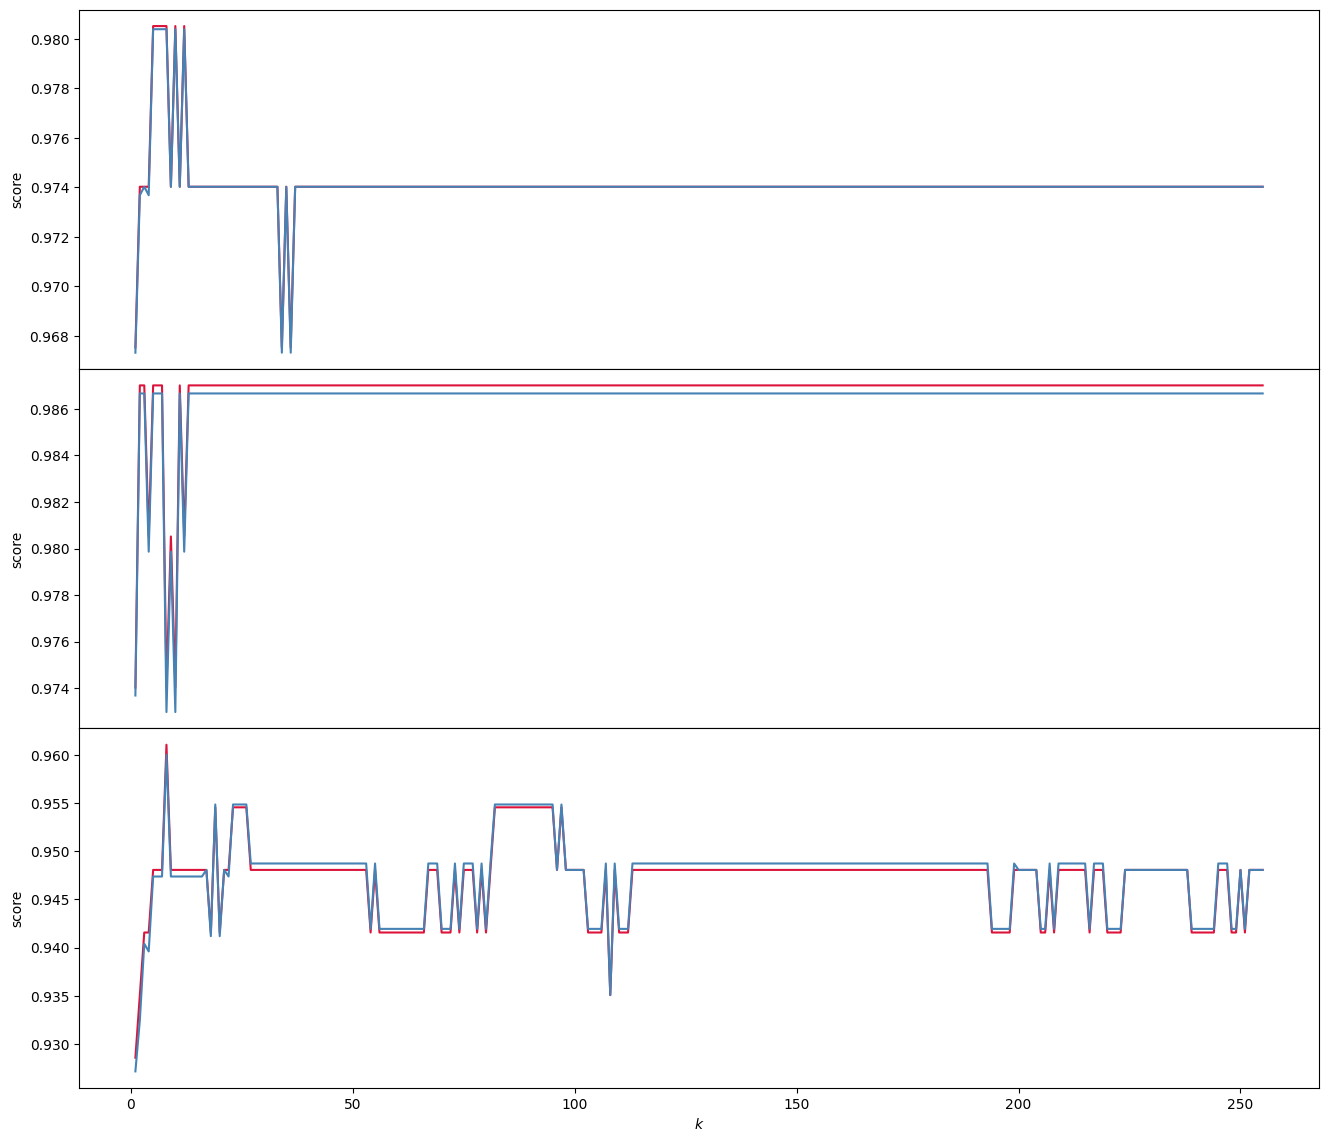

In [ ]:
def select_k(ax: plt.Axes) -> None:
    X, y = make_blobs(512, 2, centers=2, cluster_std=0.2, center_box=(0, 1))
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3)
    accuracy = []
    f1_scores = []
    k_vals = list(range(1, 256))
    for k in k_vals:
        knn = MyKNN(k=k)
        knn.fit(train_X, train_y)
        new_y = knn.predict(test_X)
        accuracy.append(accuracy_score(test_y, new_y))
        f1_scores.append(f1_score(test_y, new_y))
    ax.plot(k_vals, accuracy, color="crimson")
    ax.plot(k_vals, f1_scores, color="steelblue")
    ax.set(xlabel="$k$", ylabel="score")


fig, ax = plt.subplots(3, 1, figsize=(16, 14), sharex=True)
fig.subplots_adjust(hspace=0)
for axi in ax.flat:
    select_k(axi)

The graphs do look different from each other indeed.
Although we can see a pattern for a good value for $k$ emerging.
Certainly for any set of blobs with around this number
of points and this standard deviation a good value of
$k$ would be below $50$.

A take away message from this dataset splitting is that we can,
and should, use the data we have labels for to validate
how our model will perform on data it has not seen before.
Whichever hyperparameters we pick changes how well our model performs,
some values of hyperparameters may make our model perform very well
on the data it has been trained on but poorly on new data.
We use a subset of the data we have as a test set.
This set is not used for model training but only for the
purpose of validating the performance of the model on new data.
Once we evaluate our model - using some form of a scoring procedure
that measures the performance error - for several values of hyperparameters;
we can establish a good value to use for the hyperparameters
when using this specific algorithm to train a model on this specific data.
And the resulting model's predictions will be likely correct for new data.